In [1]:
!pip install torchreid
!pip install h5py
import torch
import torchvision
import scipy.io as io
import torchreid
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

# extra libraries
import numpy as np
import cv2
from math import comb
import copy
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
import matplotlib.patches as mpatches
from skimage.restoration import denoise_bilateral
import math
from google.colab import drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchreid: filename=torchreid-0.2.5-py3-none-any.whl size=144330 sha256=cb8421ae37a11943d52f401c0cd38a02c783420620d6073340c9faedca28b5f9
  Stored in directory: /root/.cache/pip/wheels/bb/2d/36/816a48465cefd3e58be0317648a4c52ce39ae817f935212099
Successfully built torchreid
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


In [2]:
def _convert_grayscale(rgb):
    result = np.zeros((rgb.shape[0], rgb.shape[1], rgb.shape[-1]), dtype=int)
    for idx in range(rgb.shape[-1]):
        curr_img = rgb[:, :, :, idx]
        grayscale_img = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)
        result[:, :, idx] = grayscale_img

    return result


def load_video(path):
    # load video
    video_rgb_res = io.loadmat(path)['I']  # video loaded with shape HxWx3XT where T is the total number of frames
    video_grayscale_res = _convert_grayscale(video_rgb_res)  # convert each frame of above video to grayscale
    return video_rgb_res, video_grayscale_res

In [3]:
def getSumOfDiff(image_set):
    # image_set is a set of 3 frames of size HxWx3 with each frame being a grayscale image
    # must return a sum of difference image named sod_image
    num_of_frames = image_set.shape[-1]
    denominator = comb(num_of_frames, 2)
    sod_image = np.zeros((image_set.shape[0], image_set.shape[1]))
    for idx in range(num_of_frames - 1):
        for inner_idx in range(idx + 1, num_of_frames):
            sod_image = sod_image + np.absolute(image_set[:, :, idx] - image_set[:, :, inner_idx])
    sod_image = sod_image / denominator
    return sod_image

In [4]:
def _blob_detection(diff_img_arg):
    diff_img = copy.deepcopy(diff_img_arg).astype('uint8')
    diff_img = denoise_bilateral(diff_img, sigma_spatial=5)

    # apply threshold
    thresh = threshold_otsu(diff_img)
    bw = closing(diff_img > thresh, square(20))

    # label image regions
    label_image = label(bw)

    result = []
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 100:
            # draw rectangle around segmented coins
            minr_in, minc_in, maxr, maxc = region.bbox
            width_in, height_in = maxc - minc_in, maxr - minr_in
            bbox = np.zeros(4, dtype=int)
            bbox[0], bbox[1], bbox[2], bbox[3] = minc_in, minr_in, width_in, height_in
            result.append(bbox)
    return np.asarray(result, dtype=int)

def getDetections(sod_image):
    # sod_image is a sum of difference image
    # Returns a list bounding boxes of clustered motion information from sod_image
    return _blob_detection(sod_image)


In [16]:
def getDeepFeatures(image,bbox,model):
    device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    ###########################################################################
    ########################### FILL YOUR CODE WILL ###########################
    ###########################################################################

    # DEFINE TRANSFORM TO CONVERT TO TENSOR
    transform = torchvision.transforms.ToTensor()

    # DEFINE FEATURES ARRAY BASED ON SIZE OF BOUNDING BOX
    feat = []

    with torch.no_grad():
        # FOR EACH BOUNDING BOX EXTRACT FEATURES, BRING TO CPU AND ADD TO feat
        # YOU NEED TO FIRST CROP THE BOUNDING BOX PORTION OF THE IMAGE
        # APPLY TRANSFORMS AND MAKE SURE TO REARRANGE IMAGE TO 3XHXW
        for top_x, top_y, w, h in bbox:
            extracted_img = image[top_y:top_y + h, top_x:top_x + w, :]
            # plt.figure(figsize=(5, 10))
            # plt.imshow(extracted_img)
            # plt.show()
            extracted_img = transform(extracted_img).unsqueeze(0).to(device)
            feat.append(model(extracted_img).squeeze().cpu().numpy())
    # returns feat a numpy array of size N1x2048 where N1=bbox.shape[0]
    return np.asarray(feat)

In [6]:
def getMatches(feat1, feat2):
    # feat1 and feat2 are two feature matrices of dimensions N1 x n_feat and N2 x n_feat respectively
    # where N1 = no of bboxes in frame1 and N2 = no of bboxes in frame2
    # returns matches a N x 2 matrix indicating the indices of matched bboxes. N <= min(N1,N2)

    # YOUR CODE HERE. DO NOT CHANGE ANYTHING ABOVE THIS.
    matches = []
    num_of_matched_bbox = min(feat1.shape[0], feat2.shape[0])
    for first_idx, first_feat in enumerate(feat1):
        best_match_dist = math.inf
        best_match_idx = -1
        for second_idx, second_feat in enumerate(feat2):
            dist = np.linalg.norm(first_feat - second_feat)
            if best_match_dist > dist:
                best_match_dist = dist
                best_match_idx = second_idx
        best_match = [first_idx, best_match_idx, best_match_dist]
        matches.append(best_match)

    matches.sort(key=lambda x: x[-1])
    matches = np.asarray(matches)

    return matches[:num_of_matched_bbox, :2]

In [9]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# load video
file_path = './drive/MyDrive/video.mat'
video_rgb, video_grayscale = load_video(file_path)
print('RGB video size: {}, grayscale video size: {}'.format(video_rgb.shape, video_grayscale.shape))

RGB video size: (360, 640, 3, 600), grayscale video size: (360, 640, 600)


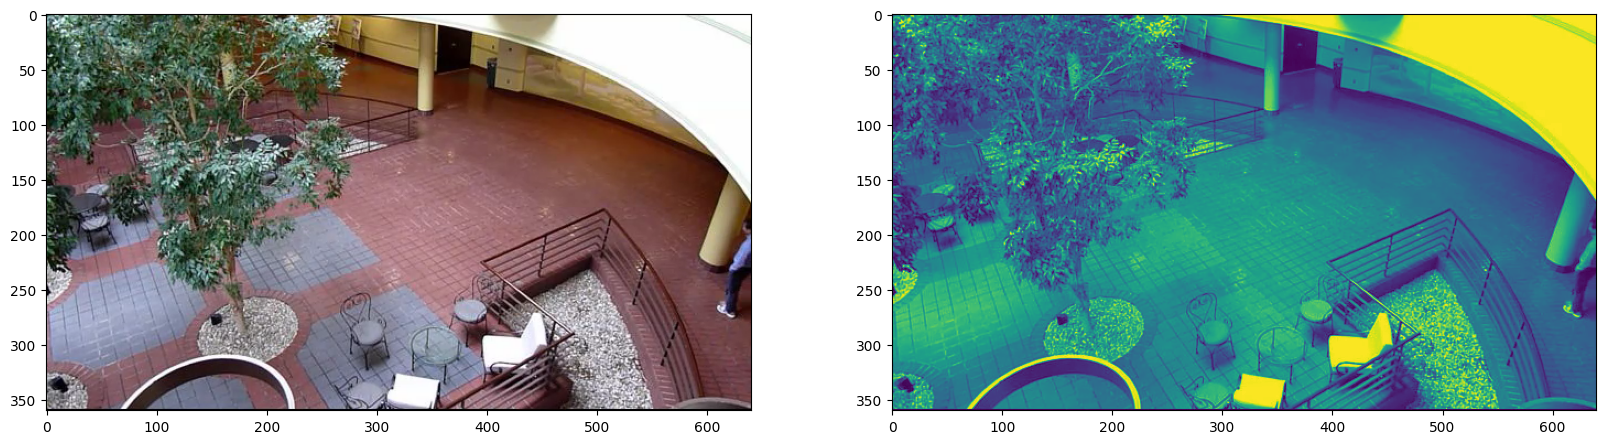

In [11]:
# display the 50th frame in both rgb and grayscale.
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(video_rgb[:, :, :, 50])
plt.subplot(122)
plt.imshow(video_grayscale[:, :, 50])
plt.show()

In [12]:
# get sample sum of difference image for 50th frame
offset = 50
D1 = getSumOfDiff(video_grayscale[:, :, offset-1:offset+2])
print('difference of frames between 49-51 size: {}'.format(D1.shape))

difference of frames between 49-51 size: (360, 640)


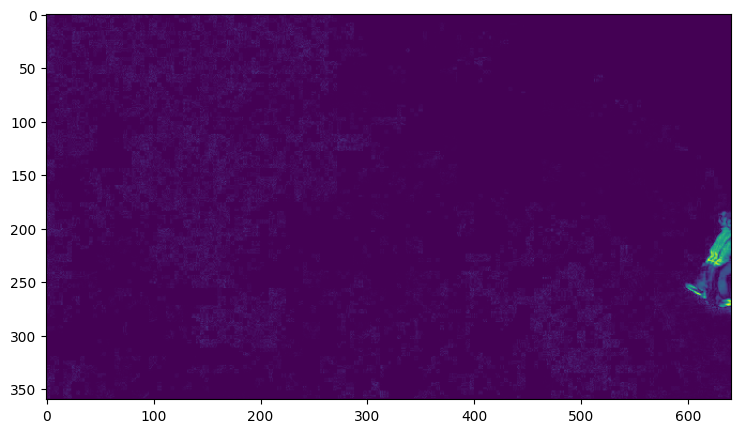

In [13]:
# write code to display D1
plt.figure(figsize=(10, 5))
plt.imshow(D1)
plt.show()

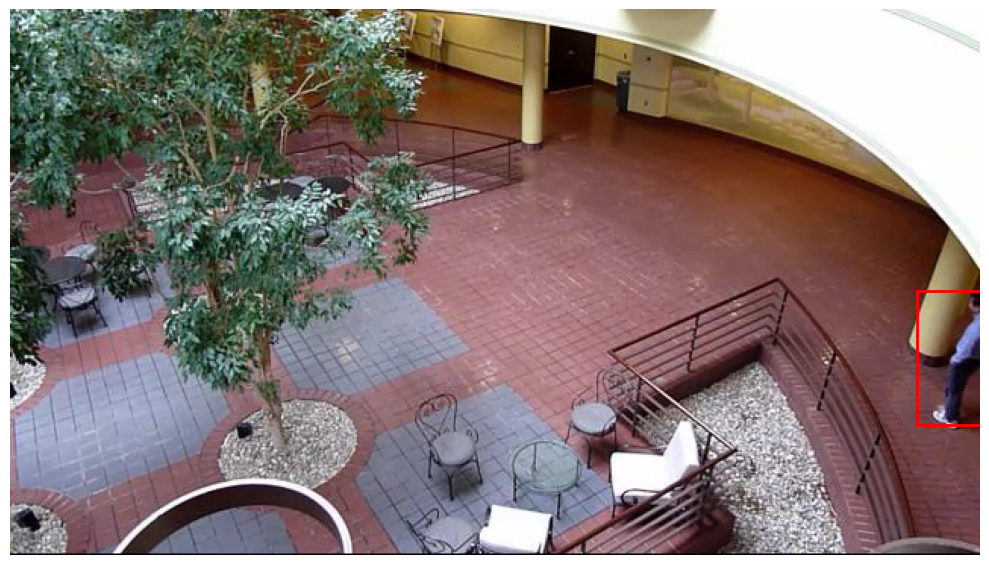

In [14]:
# get bboxes for 50th frame
# Write code to display bbox1 overlaying on top of video_rgb[:,:,:,50]
bbox1 = getDetections(D1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(video_rgb[:, :, :, 50])

for minc, minr, width, height in bbox1:
    rect = mpatches.Rectangle((minc, minr), width, height,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [17]:
detections = [(offset, bbox1)]
matchings = []
model = torchreid.models.build_model(name='resnet50', num_classes=10, loss='softmax', pretrained=True)
# # FILL CODE FOR FEATURE EXTRACTION FROM PENULTIMATE LAYER.
# # YOU NEED TO REMOVE LAST LAYER OF MODEL DEFINED ABOVE.
# # AFTER REMOVING LAST LAYER YOUR MODEL WILL OUTPUT A FEATURE OF LENGTH 2048
#
extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
feat1 = getDeepFeatures(video_rgb[:,:,:,offset],bbox1,extractor)
print('Feature shape after extractor for 50th frame: {}'.format(feat1.shape))

Feature shape after extractor for 50th frame: (1, 2048)


In [19]:
for i in range(offset,video_rgb.shape[3]-1):

    D2 = getSumOfDiff(video_grayscale[:,:,i:i+2])
    bbox2 = getDetections(D2)

    if len(bbox2) == 0:
      continue

    detections.append((i+1,bbox2))
    feat2 = getDeepFeatures(video_rgb[:,:,:,i+1],bbox2,extractor)

    M = getMatches(feat1,feat2)

    if len(M) == 0:
      continue

    matchings.append((i,i+1,M)) # appends the frame t and frame t+1 with their corresponding matchings

    D1 = D2
    bbox1 = bbox2
    feat1 = feat2
    print('offset {} is done'.format(i))

offset 50 is done
offset 51 is done
offset 52 is done
offset 53 is done
offset 54 is done
offset 55 is done
offset 56 is done
offset 57 is done
offset 58 is done
offset 59 is done
offset 60 is done
offset 61 is done
offset 62 is done
offset 63 is done
offset 64 is done
offset 65 is done
offset 66 is done
offset 67 is done
offset 68 is done
offset 69 is done
offset 70 is done
offset 71 is done
offset 72 is done
offset 73 is done
offset 74 is done
offset 75 is done
offset 76 is done
offset 77 is done
offset 78 is done
offset 79 is done
offset 80 is done
offset 81 is done
offset 82 is done
offset 83 is done
offset 84 is done
offset 85 is done
offset 86 is done
offset 87 is done
offset 88 is done
offset 89 is done
offset 90 is done
offset 91 is done
offset 92 is done
offset 93 is done
offset 94 is done
offset 95 is done
offset 96 is done
offset 97 is done
offset 98 is done
offset 99 is done
offset 100 is done
offset 101 is done
offset 102 is done
offset 103 is done
offset 104 is done
offse

In [20]:
def display_video(video):
    fig_inner = plt.figure(figsize=(5, 5))
    mov = []
    for idx in range(video.shape[3]):
        img = plt.imshow(video[:, :, :, idx], animated=True)
        plt.axis('off')
        mov.append([img])

    movie = animation.ArtistAnimation(fig_inner, mov, interval=20, repeat_delay=1000)
    plt.close()
    return movie


HTML(display_video(video_rgb).to_html5_video())

In [44]:
# Write code to display the bounding boxes frame by frame as a video using video_rgb and the list detections
# Write code to display the matched points b/w frame t and t+1 as a video using video_rgb and the list matchings
# use the centroid of the cooresponding matched bounding boxes as coordinates
# for matchings display reuse your assignment1 code to get the frame t->t+1 matchings
# refer to cell 2 for a sample animation code you need to modify it
def display_bbox_video(video, detections):
    rgb_video = copy.deepcopy(video)
    for frame_idx, bbox in detections:
        for minc, minr, width, height in bbox:
            rgb_video[:, :, :, frame_idx] = cv2.rectangle(rgb_video[:, :, :, frame_idx].astype(np.uint8).copy(), (minc, minr), (minc + width, minr + height), (255, 0, 0), 1)

    return rgb_video
    
display_bbox_video(video_rgb, detections)
HTML(display_video(display_bbox_video(video_rgb, detections)).to_html5_video())

In [ ]:
# can not implement the matchings video
# however, matchings are found using getMatches method
def display_bbox_video(video, detections, matches):
    rgb_video = np.zeros((video.shape[0], video.shape[1] * 2, video.shape[2], video.shape[3]))
    rgb_video[:, :video.shape[1], :, :] = copy.deepcopy(video)
    rgb_video[:, video.shape[1]:(video.shape[1] * 2 - 1), :, :] = copy.deepcopy(video)[:, :, :, 1:]
    rgb_video[:, video.shape[1] * 2, :, :] = rgb_video[:, video.shape[1] * 2 - 1, :, :]

    for enum_detect, frame_idx, bbox in enumerate(detections):
        for enum_bbox, (minc, minr, width, height) in enumerate(bbox):
            rgb_video[:, :, :, frame_idx] = cv2.rectangle(rgb_video[:, :, :, frame_idx].astype(np.uint8).copy(), (minc, minr), (minc + width, minr + height), (255, 0, 0), 1)
        if enum_detect < len(matches):
          first_frame, second_frame, bbox_idx = matches[enum_detect]
          for box_id in bbox_idx:
            pass
    return rgb_video
    
display_bbox_video(video_rgb, detections)
HTML(display_video(display_bbox_video(video_rgb, detections)).to_html5_video())